In [1]:
%matplotlib inline

In [2]:
from __future__ import division, print_function
import os, sys
originaldir = os.getcwd()

In [3]:
os.chdir(originaldir+'/..')
print(os.getcwd())

/home/mike/ve/ml


In [4]:
from eegkaggle.bootstrap import *
import numpy as np, scipy as sp
import scipy.io
import scipy.signal as signal
import scipy.fftpack as fftpack
import matplotlib.pyplot as plt
import matplotlib

from imp import reload

from eegkaggle.dio import dataio
from eegkaggle.vectorizers import spectral

In [5]:
ssmall,smed, slarge, slong = (4,3), (8,6), (16,12), (16,4)
matplotlib.rcParams['figure.figsize'] = slong

Functions

Data loading section

In [6]:
data = dataio.get_matlab_eeg_data_ary('/home/mike/data/train/1_1000_0.mat')

In [7]:
data.shape

(240000, 16)

In [8]:
data2 = signal.resample_poly(data, 8, 25, axis=0)
data2.shape

(76800, 16)

In [9]:
1 + False

1

In [10]:
print(data2.shape)
chunksize = 1024
nchan = data2.shape[1]
windowRatio = .25
nchunk = int(data2.shape[0] / (chunksize *windowRatio))  - int(1/windowRatio)
windowSize = chunksize

print(nchunk, chunksize, nchan)

(76800, 16)
296 1024 16


In [11]:
newdata = np.empty((nchunk, chunksize, nchan), dtype=float)
print(newdata.shape)
windowStep = int(chunksize*windowRatio)
for i in range(nchunk):
    chunk = data2[i*windowStep:(i*windowStep)+windowSize]
    chunk = np.abs(fftpack.fft(chunk, axis=0))[:chunksize]
    newdata[i] = chunk


(296, 1024, 16)


''

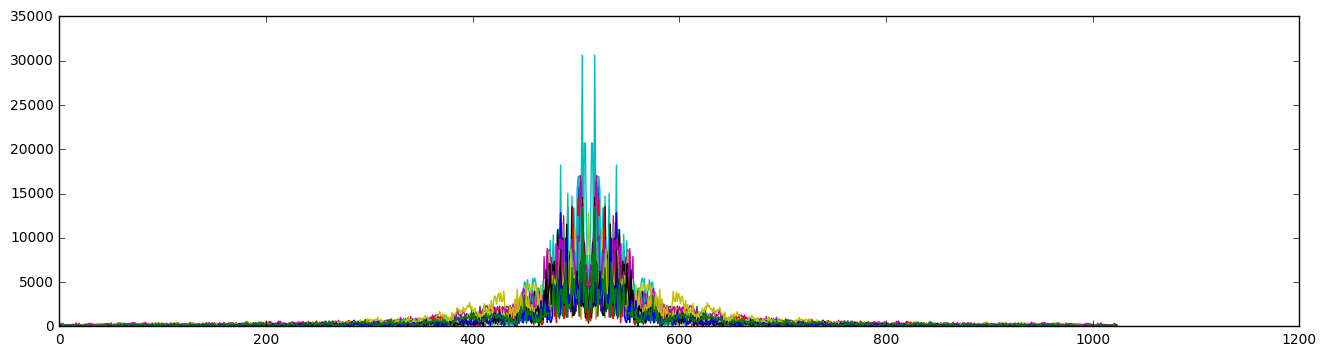

In [12]:
plt.plot(fftpack.fftshift(newdata[295]))
''

In [65]:
def resamp_and_chunk(data, chunksize=1024, up=8, down=25, windowRatio=0.25, applyFFT=False, window=('tukey',.25),
                     logFT=False, downResult=None, fs=400):
    assert data.ndim == 2, "Data must be of dimension 2!"
    nchan = data.shape[1]
    data = signal.resample_poly(data, up=up, down=down, axis=0)
    fs = fs*up/down
    if not (data.shape[0]/chunksize == data.shape[0]//chunksize):
        raise ValueError("Re-sampled Data is not evenly divisible by chunk size {} with shape {}".format(chunksize, data.shape[0]))
    windowSize = chunksize
    nchunk = int(data.shape[0] / (chunksize * windowRatio)) - int(1 / windowRatio)
    chunksize = int( chunksize/(1 + applyFFT))  # if FFT, the output frames are half the size because symmetry
    newdata = np.empty((nchunk, chunksize, nchan), dtype=float)
    windowStep = int(chunksize * windowRatio)
    winvector = signal.get_window(window, windowSize)
    winmatrix = np.array([winvector,]*nchan).T
    outsize = chunksize
    if downResult:
        outsize = int(chunksize / downResult)
    print('FS: {} chunksize: {} windowsize: {} outsize: {}'.format(fs, chunksize, windowSize, outsize))

    for i in range(nchunk):
        chunk = data[i * windowStep:(i * windowStep) + windowSize]
        if applyFFT:

            chunk = np.abs(fftpack.fft(chunk*winmatrix, axis=0))[:chunksize]
        newdata[i] = chunk
        
    if logFT:
        raise NotImplementedError("Not ready yet!!")
    if downResult:
        newdata = signal.resample_poly(newdata, 2, 2*downResult, axis=1)
    return newdata

In [66]:
data = dataio.get_matlab_eeg_data_ary('/home/mike/data/train/1_140_1.mat')
newdata = resamp_and_chunk(data, chunksize=5120, applyFFT=1, downResult=0)
print(newdata.shape)

FS: 128.0 chunksize: 2560 windowsize: 5120 outsize: 2560
(56, 2560, 16)


''

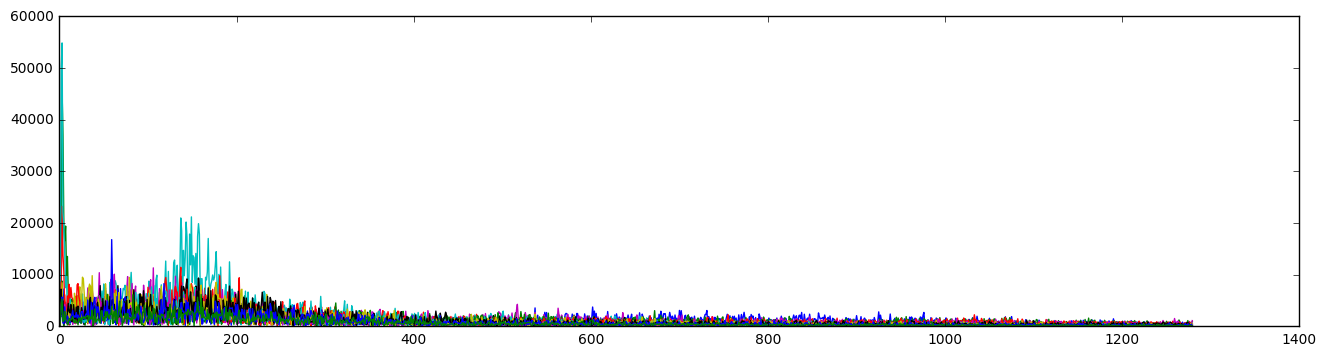

In [67]:
plt.plot(newdata[19][:newdata.shape[1]//2])
''

(2560, 16) (320, 16)


''

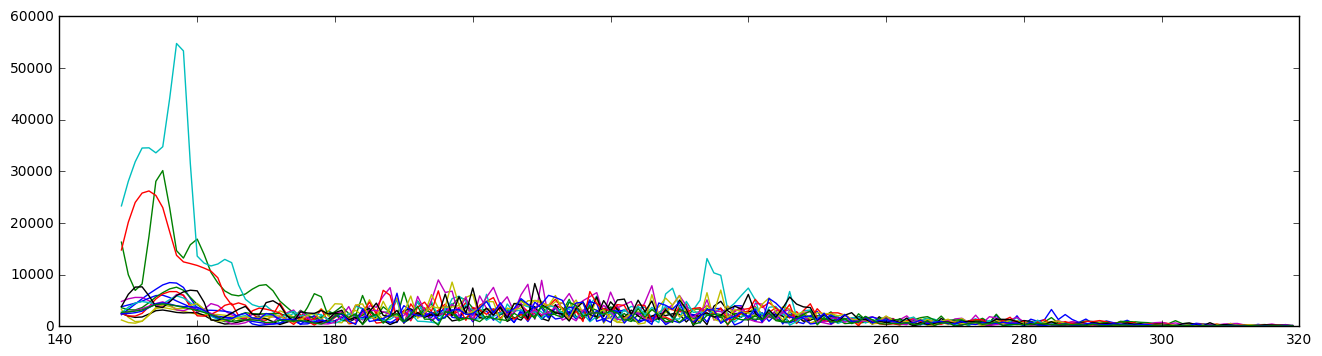

In [64]:
reload(spectral)
n = 24
sig = newdata[n]
sig = spectral.freq_log_transform(newdata[n], fs=320, hard_cutoff=newdata.shape[1]/8)
# plt.plot(spectral.freq_log_transform(newdata[19], fs=256, hard_cutoff=120))
plt.plot(sig)
print(newdata[n].shape, sig.shape)
''

In [ ]:
datas = [dataio.get_matlab_eeg_data_ary('/home/mike/data/train/1_100{}_0.mat'.format(i)) for i in range(8)]

In [ ]:
newdatas = [resamp_and_chunk(d, applyFFT=1) for d in datas]
print(newdatas[0].shape)

In [ ]:
newary = np.array(newdatas)
print(newary.shape)

In [ ]:
na = np.concatenate(newdatas, axis=0)
na.shape

In [ ]:
naa = dataio.respool_electrodes(newary)
naa.shape

In [ ]:
fn='/home/mike/data/train/1_1001_0.mat'

In [ ]:
os.path.dirname(fn)